Contains the second half of the code Karpathy explains in the video, improves the Value() class, adds more classes such as Neuron(), Layer() and more!

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5.25, 0.25)
print(xs)
ys = f(xs)
print(ys)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75  5.  ]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875
  60.    ]


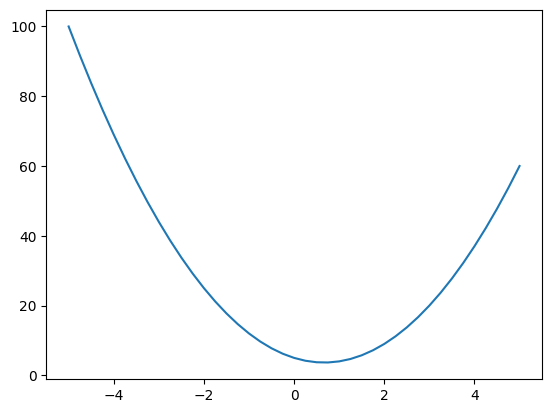

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.0000001
x = -3.0
(f(x + h) - f(x)) / h  # gives the slope/derivative for any point x

-21.999999688659955

In [8]:
# multivariable functions now

# inputs
a = 2
b = -3
c = 10.0

# func
d = a * b + c
print(d)

4.0


In [9]:
h = 0.00001

d1 = a*b + c
a += h
d2 = a*b + c

print("d1: ", d1)
print("d2:", d2) # is lower bcs increasing a leads to increasing the value of b which is negative- leading to a lower value
print("slope is: ", (d2 - d1) / h)  # diff d2 wrt a gives b, which is -3 (wrt a bcs we are only bumping up a itself here)

d1:  4.0
d2: 3.9999699999999994
slope is:  -3.000000000064062


# Neural Networks go here
starts with core implementation of `Value()` from micrograd!

In [ ]:
class Value:
    """Class for presenting a variable with some value with inbuilt arithmetic operations"""
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # self._backward performs chain rule for all inputs, with each operation having a separate definition
        self._backward = lambda: None  # the product of local derivative and the global derivative(final output of expressn wrt a variable) or the upstream gradient
        self._prev = set(_children)  # helps tracking back and in generation of computational graph
        self._op = _op  # good to know which operations led to which result
        self.label = label
    
    def __repr__(self):
        """Changes how the data object is presented"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # makes the other input an instance of Value() if it's not one already to avoid TypeError
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            """Addition's gradient essentially distributes the global gradient to the inputs"""
            # NOTE: always add the gradients, not "set" them as they will be overwritten every time the variable is used more than once!! 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward  # storing a reference to the function that can be called at any time
        
        return out 
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            """Multiplication's local derivative is just the value of the other input"""
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """Raises self to the power of other"""
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    # NOTE: The internal logic for these operations already exists inside the dunder methods used above
    
    def __rmul__(self, other):
        """Fallback for if (other * self) is not working!"""
        return self * other

    def __truediv__(self, other):
        """For (self / other)"""
        out = self * other**-1
        out._op = '/'
        return out

    def __neg__(self):
        """-self"""
        return self * (-1)

    def __sub__(self, other):
        """Handles subtraction"""
        return self + (-other)
    
    def __radd__(self, other):
        """For (other + self)"""
        return self + other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            """Local derivative for tanh is (1 - tanh(x) ** 2)"""
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topology(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topology(child)
                topo.append(v)
        build_topology(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

print("d: ", d)
print("The above expression works the same as this to give: ", (a.__mul__(b)).__add__(c))

d:  Value(data=4.0)
The above expression works the same as this to give:  Value(data=4.0)


In [37]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [12]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and graphs in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR: left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular 'record' node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

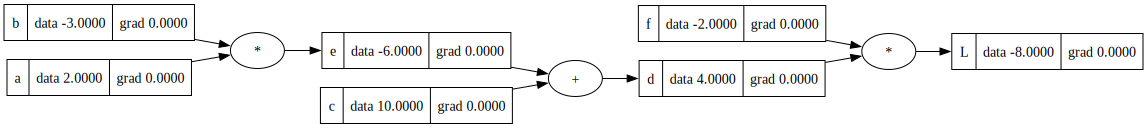

In [13]:
draw_dot(L)

## Neuron stuff!

In [38]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.88137, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = tanh(x1*w1 + x2*w2 + b)
o = n.tanh()  # needs to be implemented in Value() class!
o.label = 'o'
o.backward()

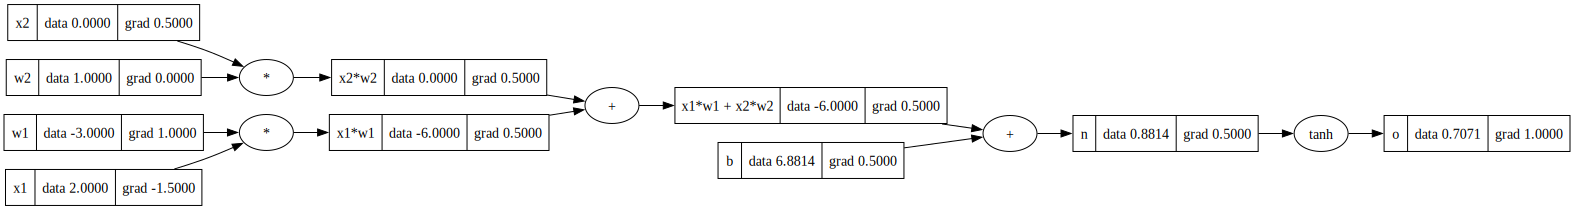

In [39]:
draw_dot(o)

## DIY tanh()

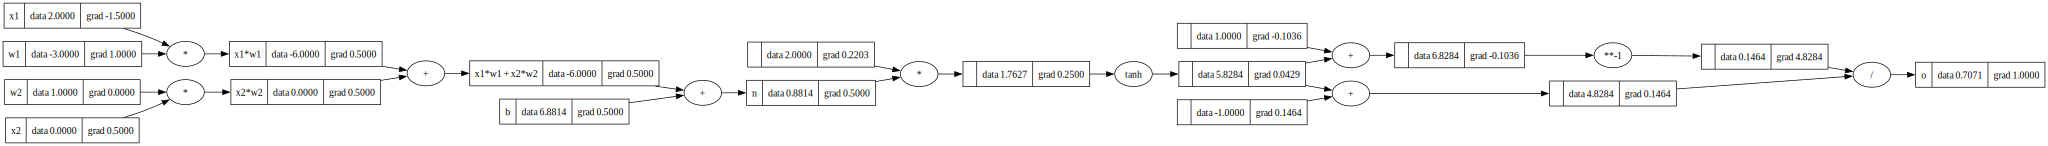

In [52]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.88137, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; 
n.label = 'n'

# o = tanh(x1*w1 + x2*w2 + b)
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

## Checking calculations with PyTorch
Naturally, we are working with scalar values here, but pytorch tensors allow much more flexibility and applications

In [ ]:
import torch

torch.Tensor([[1., 2., 3.], [4., 5., 6.]]).shape

torch.Size([2, 3])

In [55]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071050214706146
---
x1 -1.500007465833125
w1 1.0000049772220834
x2 0.5000024886110417
w2 0.0


In [58]:
o.item()  # same results as o.data.item()

0.7071050214706146

## Building blocks of Neural Networks

In [163]:
class Neuron:
    def __init__(self, nin):
        """
        nin: number of inputs fed to the neuron
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [164]:
x = [2.0, 3.0]
n = Neuron(2)  # creates a neuron which takes 2 inputs and outputs a value
n(x)

Value(data=0.9959259809636317)

In [173]:
class Layer:
    def __init__(self, nin, nout):
        """
        nin: number of inputs
        nout: number of neurons in a layer
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  # gives the first item in list if len(list) is 1, formatting sugar only!

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [175]:
x = [2.0, 3.0]
n = Layer(2, 3)  # creates a layer of 3 neurons each taking 2 inputs
n(x)

[Value(data=-0.8806871920096873),
 Value(data=0.4003668793034435),
 Value(data=0.4426671808374001)]

In [176]:
class MLP:
    def __init__(self, nin, nouts):
        # elegantly handles the indexing for each layer's inputs and outputs, where i for the default input ranges from 3, 4, 4 to 1. 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [238]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])  # creates an mlp taking 3 inputs and has 3 layers inside including the output layer
n(x)

Value(data=-0.590356579164437)

## Loss Function

In [239]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # target values

In [237]:
ypred = [n(x) for x in xs]
# squared error loss function
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.382900399379126)

In [233]:
loss.backward()

## Training the network at last!

In [179]:
# after adding parameters() to all nn blocks
print(len(n.parameters()))
print(n.parameters())

41
[Value(data=0.04441881063923203), Value(data=-0.5814525735373977), Value(data=0.5240691742987853), Value(data=-0.39950274226828286), Value(data=0.3129515735895858), Value(data=-0.6827399820360218), Value(data=-0.8586434832383976), Value(data=0.3452515171809747), Value(data=0.8190439752030529), Value(data=-0.8245148346195663), Value(data=-0.2932338760028692), Value(data=-0.5091788213084918), Value(data=-0.0983869004025919), Value(data=-0.40873027023834396), Value(data=0.9316894748218871), Value(data=0.5619063169314304), Value(data=0.3933885708276301), Value(data=-0.5998696233879632), Value(data=-0.5923826137657586), Value(data=0.5895467939613006), Value(data=-0.42937517806787984), Value(data=-0.08734340008737185), Value(data=0.13716667072427113), Value(data=-0.8867239760371652), Value(data=-0.6132063422059681), Value(data=0.4350845059143811), Value(data=0.5181788013627828), Value(data=0.8784723029144446), Value(data=0.8038832928970112), Value(data=-0.7579580127394003), Value(data=0.9

In [223]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [247]:
ypred

[Value(data=0.9321841714490071),
 Value(data=-0.9356051977428785),
 Value(data=-0.9169718687815596),
 Value(data=0.9525786177672364)]

In [245]:
# ease of access
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.295761048566243)

In [246]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        # zero grad'ing here to reset our gradients after each backward pass
        p.grad = 0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 8.588145724798844
1 4.870673903991353
2 2.4552105980427212
3 1.1165924500637996
4 0.5577322907443739
5 0.18480644951294267
6 0.09691810420748545
7 0.07323302875411503
8 0.058926772049151026
9 0.0491502283269286
10 0.04205208365115424
11 0.03668213338707646
12 0.03249019202978154
13 0.029134650965902537
14 0.026392603982476684
15 0.024112816923067066
16 0.02218933378285231
17 0.020545876739158125
18 0.019126235188668718
19 0.01788813522628387
